# LSTM Statefulness, Batch Size and Sequence Length in Keras

Rather sooner than later, every one using LSTMs, will stumble upon the concept of statefulness. I personally found it hard to get a good grasp whilst reading the Keras documentation and other blogs. Especially the interplay between sequence length, batch size and state initially eluded me. The goal of this blog is too significantly steepen your learning curve on this topic. We will first have a closer look at sequential data and LSTM, then investigate how stateful LSTMs work, discuss use cases, and finally cover the Keras implementation.

## 1. Sequential data and LSTM

This blog assumes you already know about LSTMs. Should your knowledge be a bit rusty, Colah’s blog (https://colah.github.io/posts/2015-08-Understanding-LSTMs/) might be a good place to brush it up. But I would nevertheless like to clarify one aspect of sequential data and LSTM that wasn’t immediately apparent to me when I got started with them. 

LSTMs are capable of exploiting the sequential nature of the inputs and/or outputs they are given. Classic examples of such inputs are text, speech, time series, event logs, etc. The basic structure is always the same: the input sequences have the same length (=sequence length). If not, padding is used to make sure they are. Both input and output sequences can have a length of one or more.

Some data is naturally organized in sequences, for example short sentences in a sentiment analysis problem. Every sentence will become an input sequence to the LSTM model, with padding where the number of words is smaller than the chosen sequence length and truncation in the opposite case. The output sequence will have a length of one.

Less intuitively, LSTMs can also be used to generate sequences from singular inputs for example in image captioning where for every image a sentence describing it is generated. The input sequences have a length of one, the output sequences are longer.

Time series (such as sales data, electricity consumption, etc.), however, do not automatically fit in the above structures. There are no recognizable input or output sequences. They are in fact one long sequence by themselves:

$$x_1, x_2,x_3, ..., x_{N-1}, x_N$$

If we wish to predict the next value(s) succeeding the a given time series, we need to reframe the problem as an LSTM will obviously not work when trained on one sequence with the length of the series. We therefore create a transformed dataset applying windowing with the size of the window our chosen sequence length T: 

$$x_1, x_2,x_3, ..., x_{T-1}, x_T \rightarrow x_{T+1}$$
$$x_2, x_3,x_4, ..., x_{T}, x_{T+1} \rightarrow x_{T+2}$$
$$...$$
$$x_{N-T}, x_{N-T+1},x_{N-T+2}, ..., x_{N-2}, x_{N-1} \rightarrow x_{N}$$

Statefulness mostly concerns time series or other long sequences. In the following, we will assume to be working with such a long time series or sequence. 

## 2. How stateful LSTMs work
Within the context of LSTMs, different interpretation for the term ‘state’ exist which can lead to confusion. ’State’ can refer to either the hidden state or the cell state of an LSTM cell. The former, often denoted h, constitutes the output of the cell and is passed to the next layer. The latter, referred to as c, can be interpreted as the cell’s memory and is the state Keras refers to when talking about statefulness. In this blog, I will always refer explicitly to either the hidden or cell state.

Consider the visualization of a single cell and corresponding formulas (in vector format, applying to all cells in a layer) below. 


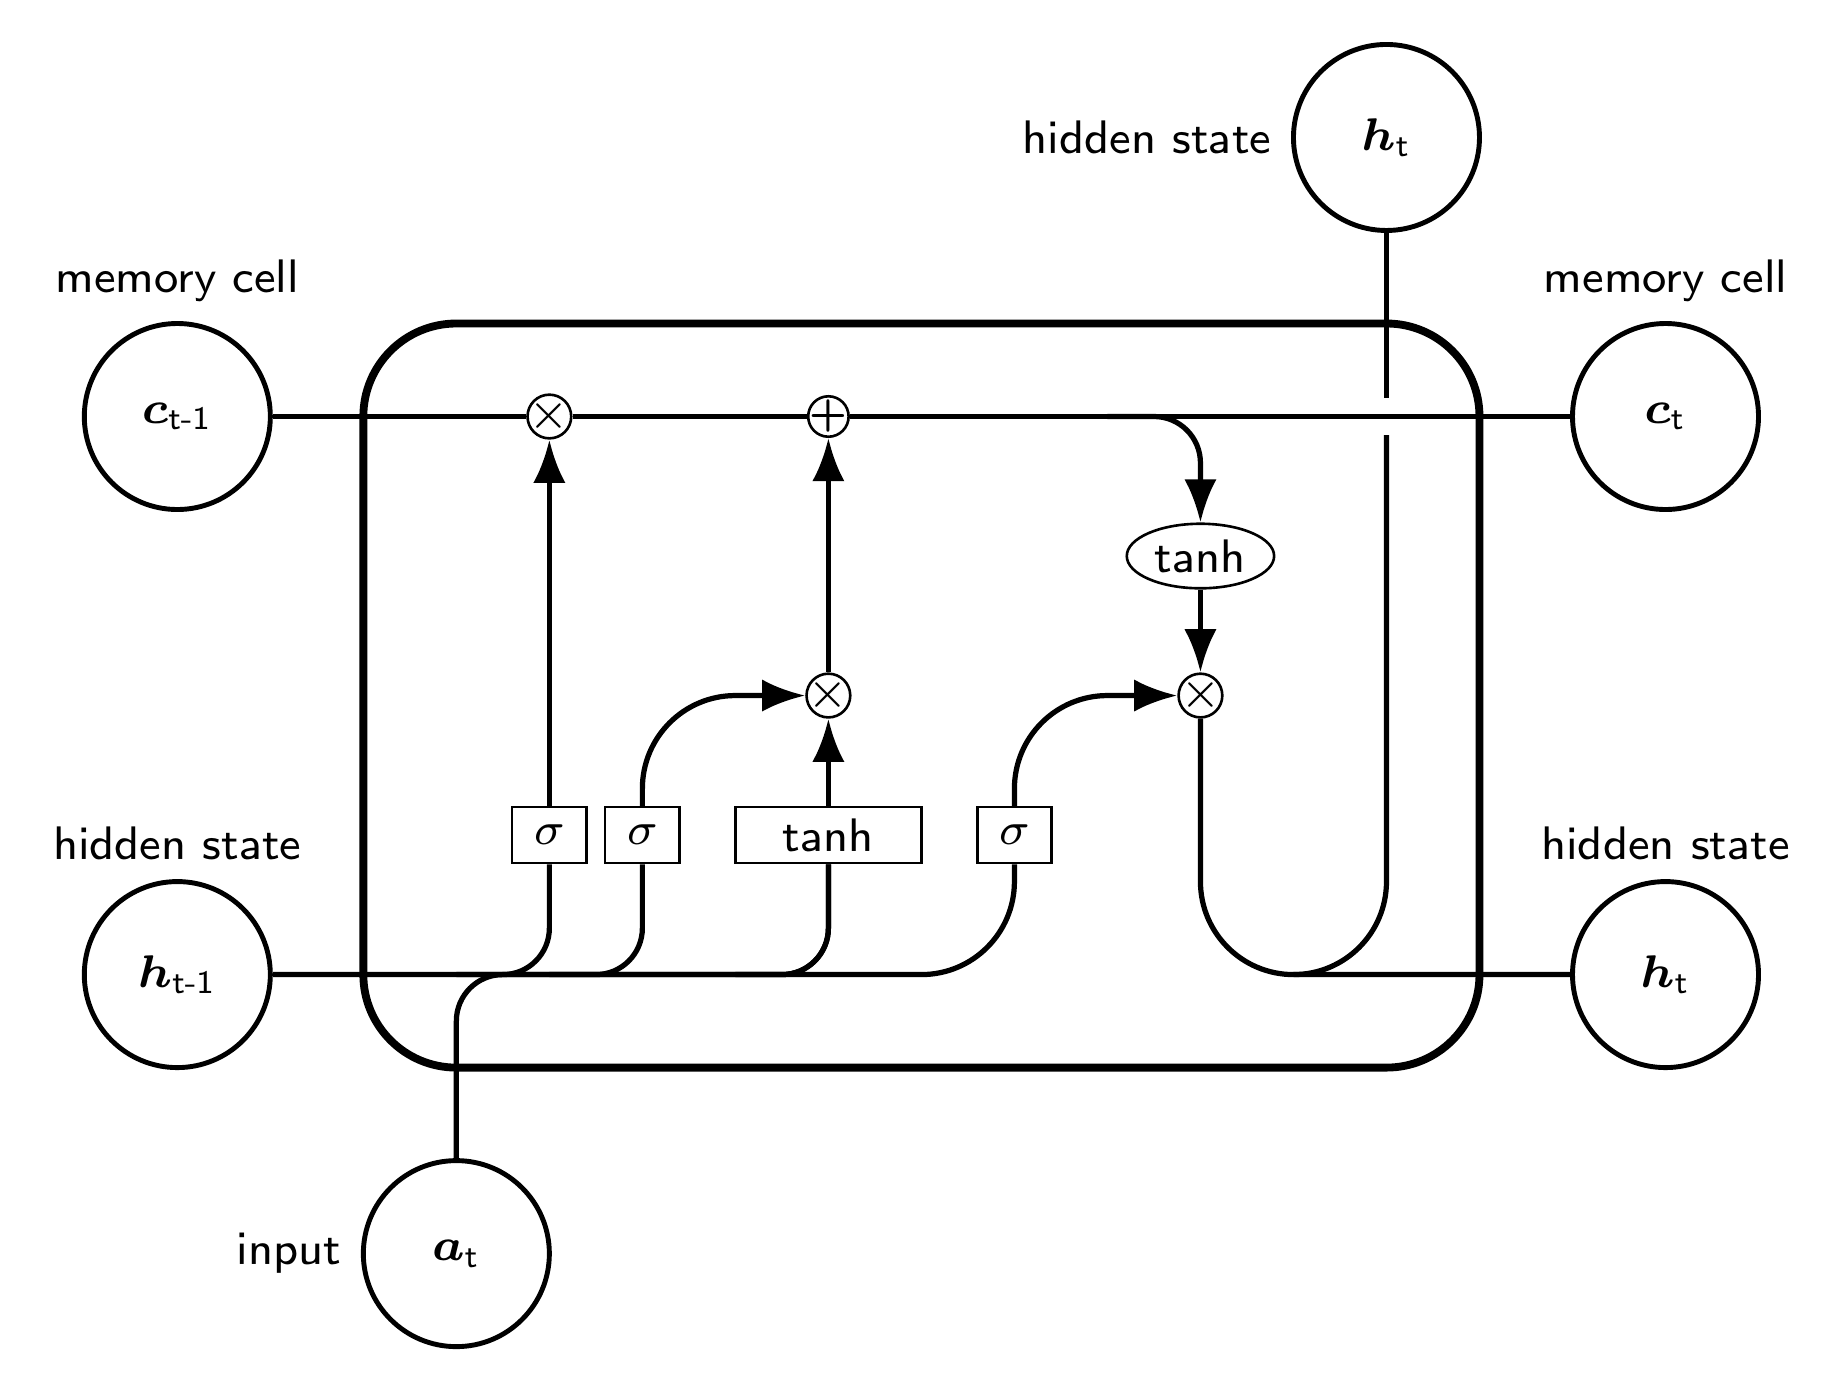

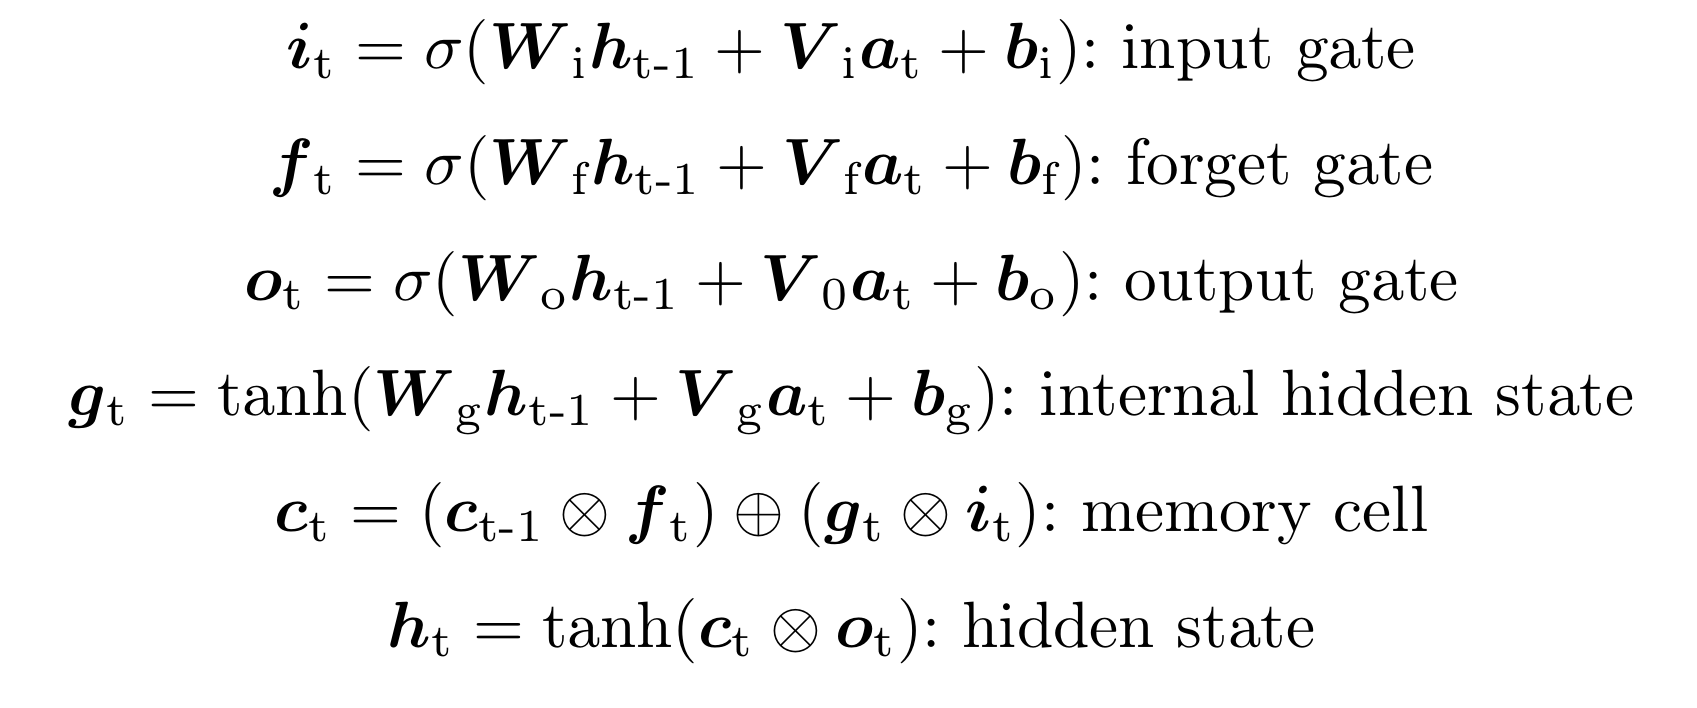

You can see that in each forward pass, every instance at time step t will take four inputs: the hidden state ht-1 and cell state ct-1 from its predecessor, weights (all W and V) and the output values at from the lower layer it is connected to (inputs xt if the LSTM layer is the first hidden layer of the network). The cell will then compute new values ht and ct, which it will pass to its successor at time step t+1. As already mentioned above, the final ht will move up to the next layer above (potentially all h, if the next layer is an LSTM layer as well).


In the following, we will ignore the intricacies of the LSTM cells and just concentrate on the values h and c. Let’s assume a univariate time series or sequence with six samples, a batch size of three and sequence length T. We will observe a single node with an LSTM layer during its first two epochs of training. The figure below shows a stateless LSTM:

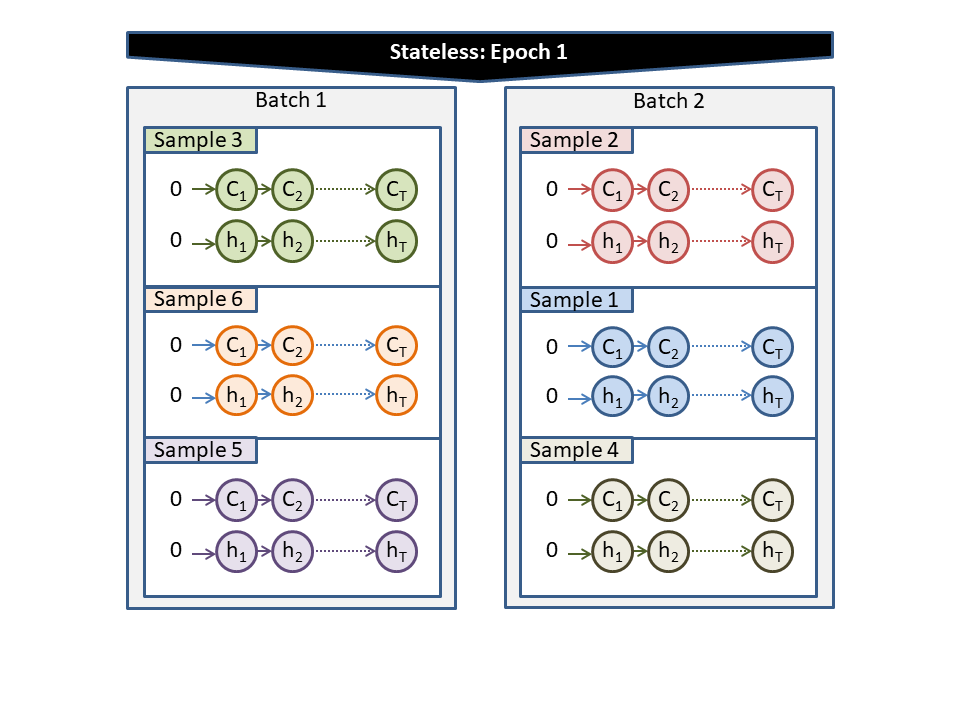

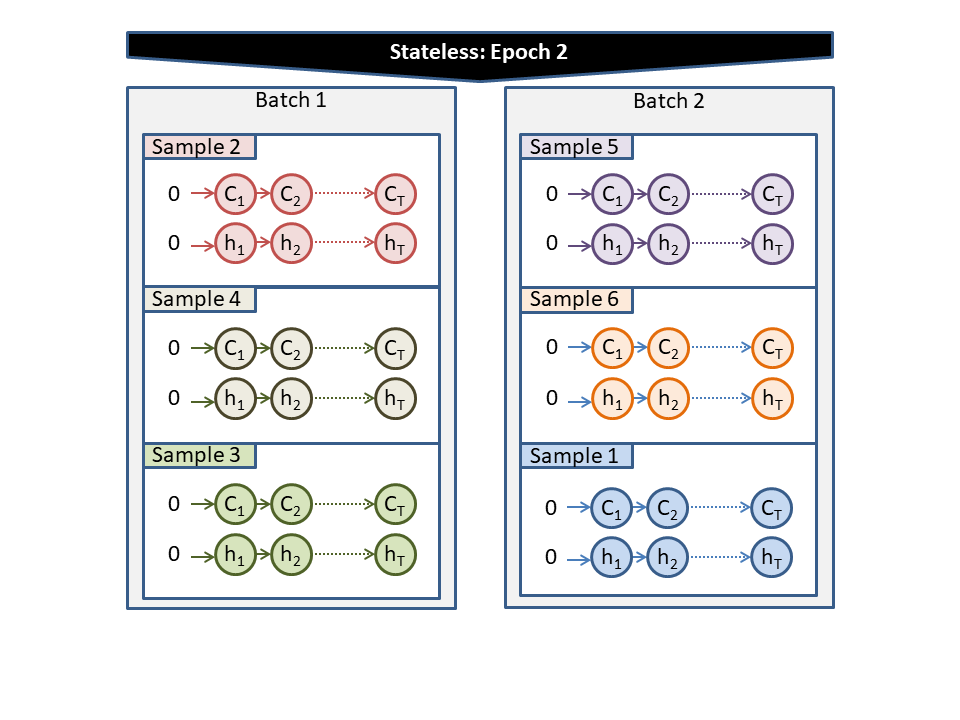

In its default mode, Keras will reshuffle the dataset between epochs. At the start of the first epoch, the values for values h and c are set to zero for all samples in the dataset. They then evolve to their final values hT  and cT at time step T at the end of their sequences.  The cell’s weights (all W and V), which are shared between the samples and time steps, are now recalculated and passed to the next epoch. This is not shown on the graph. The hidden and cell states are not passed with them.

In stateless mode, long term memory does not mean that the LSTM will remember the content of the previous batches. It only remembers within the individual sequences (which can be long).

Contrast this to a stateful LSTM network:


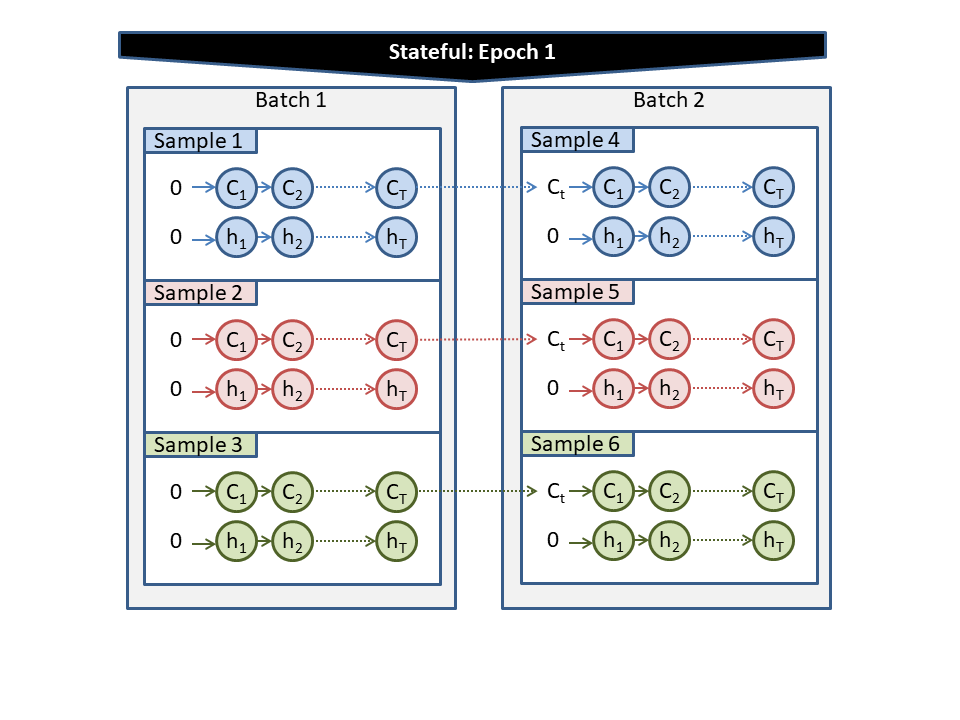

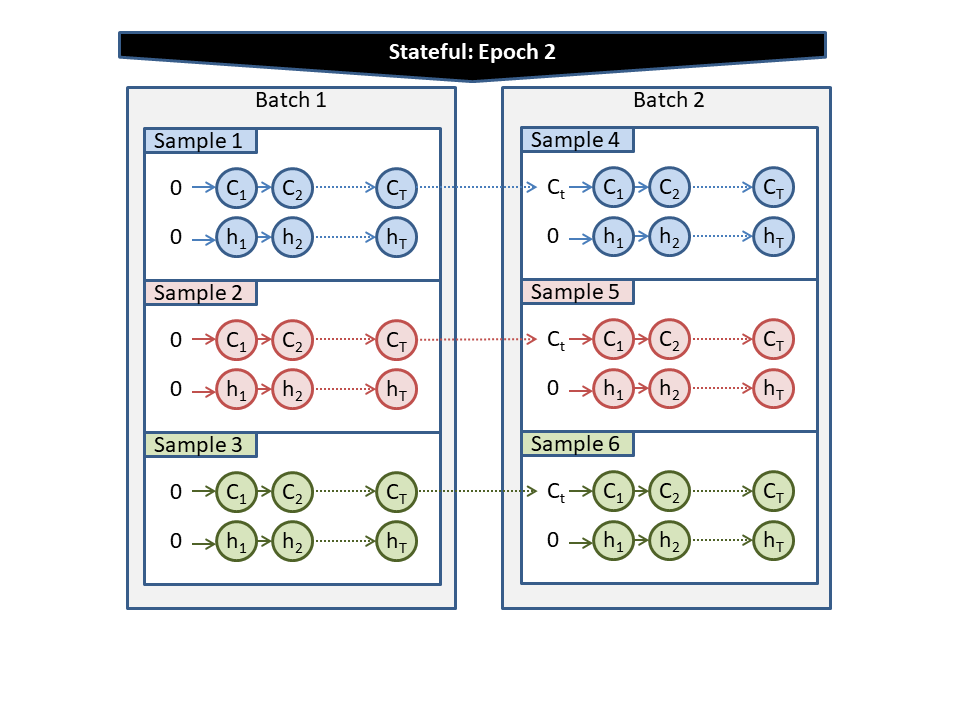

Here, the final cell states cT from the first batch serve as initial values for the corresponding samples in the next batch. Furthermore, the samples are not reshuffled between the epochs.

One way to interpret this is to consider the stateless model to be training six sequences of length T, whereas the stateful LSTM network trains three sequences of length 2T per epoch. Clearly, there has to be some form of relationship between batches 4 and 1, 5 and 2, 6 and 3 for the stateful setup to make sense.


## 3. Use cases for stateful LSTM
The main use case for stateful LSTMs can be found in forecasting problems with periodic data. A retailer’s sales will have a clear weekly pattern. To reflect this periodicity, we should use a batch size of seven. The sample having sales on a Monday as a target in the first batch will this pass its cell state to the corresponding cell with a target for sales on a Monday in the second batch and so on. 
The second use case is context. Imagine you have a very long dataset. For prediction it is important to have a sense of what happened in all previous time steps. This context can be created increasing the sequence length. But given the size of the dataset, you cannot possibly make the sequence length of the network long enough. This is where a stateful LSTM network can help. By choosing a batch size of one (called stochastic mode), information captured by the cell states (one for every node) will flow through ALL samples. 

Note that the preferred sequence length for the network is not necessarily related the batch size. You can find the optimal sequence length by experimenting with the network.


## 4. Training and Prediction with stateful LSTMs with Keras
It is now time to turn the implementation of the above in Keras. Fortunately, this is rather easy: we basically implement a stateless LSTM, which is the Keras default, and make following modifications:

1.	Make sure that the length of your training and test sets is a multiple of the batch size. You will need to truncate if that is not the case.



2.	Specify the batch size at the creation of the network. You cannot specify the batch size when fitting the model. Keras needs to know the batch size in advance so that it can create the necessary structures to store the cells’ states:
```python
model.add(LSTM(nodes, batch_input_shape=(batch_size, sequence length, n_features), return_sequences=False)
```
Use ‘return_sequences=True’ if the LSTM layer is followed by another LSTM layer.


3.	Make the LSTM layer(s) stateful, by adding ‘stateful=True’
```python
model.add(LSTM(nodes, batch_input_shape=(batch_size, sequence length, n_features), return_sequences=False, stateful=True) 
```

4.	Train online, reset cell states after every epoch, and prevent shuffling. In stateful mode, Keras will not reset the cells’ states at all. Since we want it to do so after every epoch, we have to train in online mode and reset these states manually. Also, Keras needs to be instructed to not reshuffle the data between epochs:
```python
for epoch in range(nr_epochs):
          model.fit(X_train, y_train, epochs=1, batch_size=batch_size, shuffle=False)
          model.reset_states()
```

5.	Seed your model before predicting. Like when training an epoch, Keras will automatically update the cells’ states when predicting. We can use this property to update the states using the training set to get correct predictions of the time steps thereafter:
```python
yhat = model.predict(X_train, batch_size=batch_size)
```
6.	Predict using your test set
```python
yhat = model.predict(X_test, batch_size=batch_size)
```	


When a stateful LSTM network is trained using a certain batch size, Keras requires you to use the same batch size when predicting. If, however, you wish to make a one-day prediction for the above sales example, which had a weekly periodicity and was hence trained with a batch size of seven, you have to resort to an easy workaround:

1.	Create a new, identical model (named new_model). The only difference is that batch size in the LSTM layers  is now the new batch size:
```python
model.add(LSTM(nodes, batch_input_shape=(new_batch_size, sequence length, n_features), return_sequences=False, stateful=True) 
```	
2.	Transfer the original model’s weights to the new model and compile it
```python
weights = model.get_weights()
new_model.set_weights(weights)
new_model.compile(…)
          ```	
3.	Predict with the new batch size:
```python
weights = new_model.predict(X, batch_size=new_batch_size)
          ```




# 5. Two code examples and concluding remarks
For a toy example with an entire code listing, check out Jason Brownlee’s (https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/). 

Jason also wrote a blog comparing stateless against a stateful LSTM network, again with the code published: (https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/). It shows that stateful LSTM networks will not always yield better results, a statement which I can subscribe to from my experience. You have to try to know. The dataset in this blog, however, is much too small to make any generalizable conclusions, but you might find the code useful.

To conclude, if you find yourself with a time series or sequence forecasting problem and your data show periodicity do try out a stateful LSTM network. Equally, if your dataset is very long and you need context for making the next time step’s prediction, you might consider a stateful LSTM network.

There is no guarantee, however, that your stateful LSTM network will outperform a stateless one. Also be aware that a batch size of 1 may impact the speed, accuracy and stability of your model, either positively or negatively. The evidence seems to be inconclusive. 
